In [1]:
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # 깃 클론
!mkdir 'data' # 폴더 생성
!unzip /home/yunkwan/project/AI_UWB_GANT/pix2pix-pytorch/dataset/facades.zip -d /home/yunkwan/project/AI_UWB_GANT/data; # 압축 풀기

fatal: destination path 'pix2pix-pytorch' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
Archive:  /home/yunkwan/project/AI_UWB_GANT/pix2pix-pytorch/dataset/facades.zip
replace /home/yunkwan/project/AI_UWB_GANT/data/facades/test/a/cmp_b0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [15]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, path2img, direction='b2a', transform=False):
        super().__init__()
        self.direction = direction
        self.path2a = join(path2img, 'a')
        self.path2b = join(path2img, 'b')
        self.img_filenames = [x for x in listdir(self.path2a)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
        b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        if self.direction == 'b2a':
            return b,a
        else:
            return a,b

    def __len__(self):
        return len(self.img_filenames)
    
    
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

# 데이터셋 불러오기
path2img = '/home/yunkwan/project/AI_UWB_GANT/data/facades/train'
train_ds = FacadeDataset(path2img, transform=transform)

# 샘플 이미지 확인하기
a,b = train_ds[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

NameError: name 'Dataset' is not defined

In [3]:
# 데이터 로더 생성하기
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [16]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

# check
x = torch.randn(16, 3, 256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

torch.Size([16, 64, 128, 128])
torch.Size([16, 128, 128, 128])


In [17]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        print(d8.shape)
        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

# check
x = torch.randn(16,3,256,256,device=device)
model_gen = GeneratorUNet().to(device)
out = model_gen(x)
print(out.shape)

torch.Size([16, 512, 1, 1])
torch.Size([16, 3, 256, 256])


In [8]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# check
x = torch.randn(16,64,128,128,device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


In [9]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)       # receptive 3
        self.stage_2 = Dis_block(64,128)    # 3+(3-1)2 = 7
        self.stage_3 = Dis_block(128,256) # 7 +(3-1)2^2 = 15 
        self.stage_4 = Dis_block(256,512) # 15 +(3-1)2^3  = 31

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성    31 + (3-1)2^4 

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x
# check
x = torch.randn(16,3,256,256,device=device)
model_dis = Discriminator().to(device)
out = model_dis(x,x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [10]:
# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [11]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



def imshow(img):
    img = img.reshape(-1,3,256,256)
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img)
    plt.show()

def imshow_grid(img):
    img = img.reshape(-1,3,256,256)
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

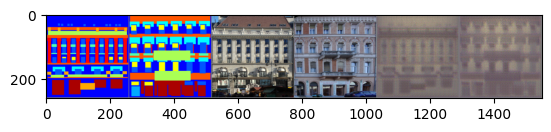

Epoch 25: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

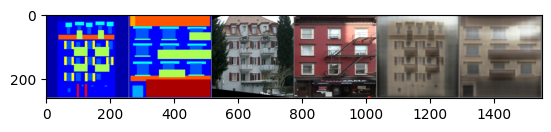

Epoch 50: 100%|██████████| 4/4 [00:03<00:00,  1.50it/s]

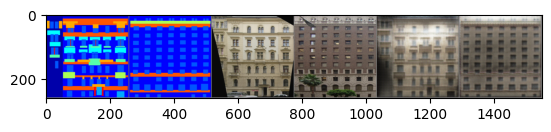

Epoch 75: 100%|██████████| 4/4 [00:03<00:00,  1.47it/s]

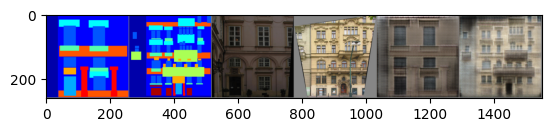

Epoch 100: 100%|██████████| 4/4 [00:03<00:00,  1.57it/s]

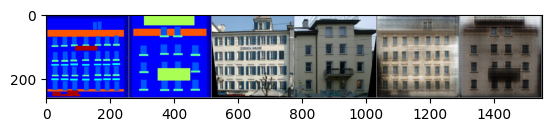

Epoch 100: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


In [13]:
import time
from tqdm import tqdm
import math
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    start = time.time()
    batch_num = math.ceil(len(train_dl.dataset) / batch_size)
    model_gen.train()
    model_dis.train()

    with tqdm(total=batch_num, position=0, leave=True, desc=f"Epoch {epoch + 1}") as pbar:
        for a, b in train_dl:
            ba_si = a.size(0)

            # real image
            real_a = a.to(device)
            real_b = b.to(device)

            # patch label
            real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
            fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

            # generator
            model_gen.zero_grad()

            fake_b = model_gen(real_a) # 가짜 이미지 생성
            out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

            gen_loss = loss_func_gan(out_dis, real_label)
            pixel_loss = loss_func_pix(fake_b, real_b)

            g_loss = gen_loss + lambda_pixel * pixel_loss
            g_loss.backward()
            opt_gen.step()

            # discriminator
            model_dis.zero_grad()

            out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
            real_loss = loss_func_gan(out_dis,real_label)
            
            out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
            fake_loss = loss_func_gan(out_dis,fake_label)

            d_loss = (real_loss + fake_loss) / 2.
            d_loss.backward()
            opt_dis.step()

            loss_hist['gen'].append(g_loss.item())
            loss_hist['dis'].append(d_loss.item())

            batch_count += 1
            pbar.update(1)
        # print(epoch)
        if (epoch+1) % 25 == 0 or (epoch) == 1:
            model_gen.eval()           
            fake_imgs = model_gen(a.to(device))[0:2].detach().cpu()
            real_imgs = b[0:2]
            img = torch.cat((a[0:2],real_imgs, fake_imgs), 0)
                                   
            imshow_grid((img))
                    
            
                
            
        

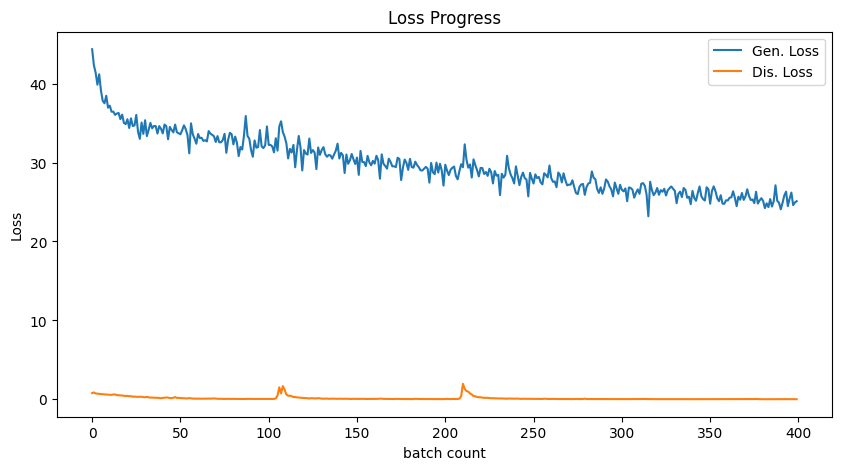

In [14]:
import matplotlib.pyplot as plt

# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()



# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [3]:
# 가중치 불러오기
import torch
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        real_imgs = b
        break
    
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')

NameError: name 'path2weights_gen' is not defined

In [14]:
import json
import os
import numpy as np
import csv
import easydict
import cv2
import torchvision.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable

from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
from time import sleep
from torchvision import datasets


btsize = 32
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=btsize, shuffle=True)
    
    
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
        
class Generator(nn.Module):
    """Generator, 논문에 따르면 100개의 noise를 hypercube에서 동일한 확률값으로 뽑고
       z를 200개, y를 1000개의 뉴런으로 전달합니다. 이후 1200차원의 ReLU layer로 결합하고
       Sigmoid를 통해 숫자를 만들어냅니다."""
    def __init__(self):
        super().__init__()
        self.num_classes = 10 # 클래스 수, 10
        self.nz = 100 # 노이즈 수, 100
        self.input_size = (1,28,28)

        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)

        # # noise와 label을 결합할 용도인 label embedding matrix를 생성합니다.
        self.label_emb = nn.Embedding(10, 10)
        # 임베딩 파라미터를 선언한 후 forward 메소드를 수행하면 (입력차원, 임베딩차원) 크기를 가진 텐서가 출력
        # 이때 forward 메소드의 입력텐서는 임베딩 벡터를 추출할 범주의 인덱스이므로 무조건 정수타입(LongTensor)이 들어가야된다.
        # ex) forward 메소드에 (2,4) 크기의 텐서가 입력으로 들어가면 (2,4,10) 크기의 텐서가 출력
        # https://hongl.tistory.com/244
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )


    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        z = input.view(input.size(0), 100)  # 노이즈 (batch_size, 100)
        c = self.label_emb(label)  # 라벨 (10,10)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)
class Discriminator(nn.Module):
    """Discriminator, 논문에 따르면 maxout을 사용하지만
       여기서는 그냥 Fully-connected와 LeakyReLU를 사용하겠습니다.
       논문에서는 Discriminator의 구조는 그렇게 중요하지 않다고 말합니다"""
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        # 벡터화의 한 과정
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = input.view(input.size(0), 784)
        c = self.label_emb(label)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()
    

def imshow(img):
    img = img.reshape(-1,1,28,28)
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = img.reshape(-1,1,28,28)
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Epoch 1: 100%|█████████▉| 1870/1875 [00:18<00:00, 103.25it/s]

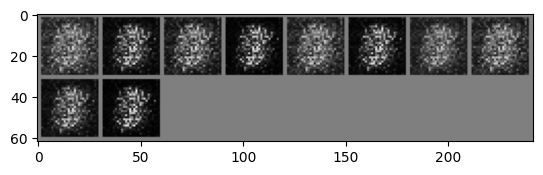

Epoch 1: 100%|██████████| 1875/1875 [00:18<00:00, 101.45it/s]


18.482055187225342
Done!


Epoch 2: 100%|██████████| 1875/1875 [00:19<00:00, 95.01it/s] 


19.736239194869995
Done!


Epoch 3: 100%|██████████| 1875/1875 [00:17<00:00, 105.04it/s]


17.850897550582886
Done!


Epoch 4: 100%|██████████| 1875/1875 [00:18<00:00, 102.26it/s]


18.33723735809326
Done!


Epoch 5: 100%|██████████| 1875/1875 [00:18<00:00, 102.48it/s]


18.296359539031982
Done!


Epoch 6: 100%|█████████▉| 1867/1875 [00:17<00:00, 110.35it/s]

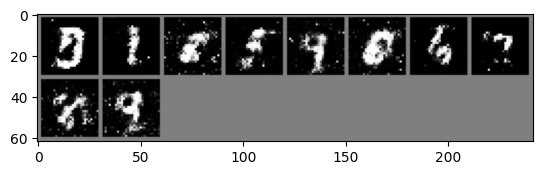

Epoch 6: 100%|██████████| 1875/1875 [00:17<00:00, 106.45it/s]


17.615041971206665
Done!


Epoch 7: 100%|██████████| 1875/1875 [00:17<00:00, 106.74it/s]


17.566263914108276
Done!


Epoch 8: 100%|██████████| 1875/1875 [00:17<00:00, 105.60it/s]


17.75719928741455
Done!


Epoch 9: 100%|██████████| 1875/1875 [00:17<00:00, 109.90it/s]


17.061737060546875
Done!


Epoch 10: 100%|██████████| 1875/1875 [00:18<00:00, 103.97it/s]


18.034791469573975
Done!


Epoch 11:  99%|█████████▉| 1864/1875 [00:17<00:00, 109.50it/s]

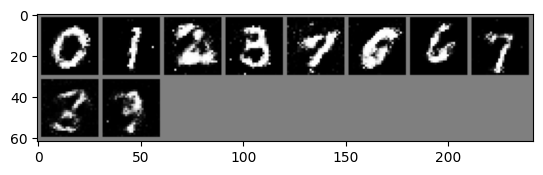

Epoch 11: 100%|██████████| 1875/1875 [00:17<00:00, 106.55it/s]


17.598350763320923
Done!


Epoch 12: 100%|██████████| 1875/1875 [00:18<00:00, 103.72it/s]


18.077420711517334
Done!


Epoch 13: 100%|██████████| 1875/1875 [00:17<00:00, 108.22it/s]


17.32627773284912
Done!


Epoch 14: 100%|██████████| 1875/1875 [00:17<00:00, 106.06it/s]


17.68018937110901
Done!


Epoch 15: 100%|██████████| 1875/1875 [00:17<00:00, 106.46it/s]


17.612581968307495
Done!


Epoch 16: 100%|██████████| 1875/1875 [00:17<00:00, 102.78it/s]

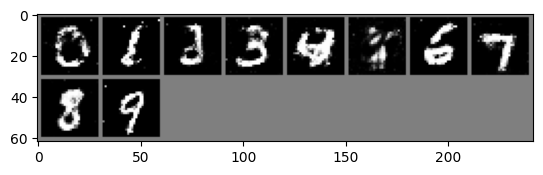

Epoch 16: 100%|██████████| 1875/1875 [00:17<00:00, 105.58it/s]


17.760084867477417
Done!


Epoch 17: 100%|██████████| 1875/1875 [00:18<00:00, 102.56it/s]


18.283214807510376
Done!


Epoch 18: 100%|██████████| 1875/1875 [00:17<00:00, 110.23it/s]


17.010858058929443
Done!


Epoch 19: 100%|██████████| 1875/1875 [00:18<00:00, 102.68it/s]


18.262555360794067
Done!


Epoch 20: 100%|██████████| 1875/1875 [00:17<00:00, 108.80it/s]


17.233959197998047
Done!


Epoch 21: 100%|█████████▉| 1869/1875 [00:17<00:00, 106.03it/s]

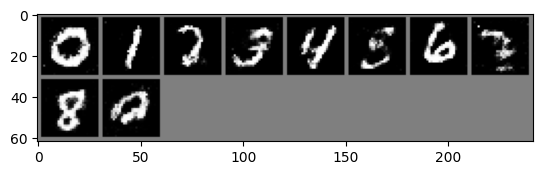

Epoch 21: 100%|██████████| 1875/1875 [00:17<00:00, 104.49it/s]


17.94623112678528
Done!


Epoch 22: 100%|██████████| 1875/1875 [00:17<00:00, 108.15it/s]


17.338237524032593
Done!


Epoch 23: 100%|██████████| 1875/1875 [00:17<00:00, 105.75it/s]


17.732522010803223
Done!


Epoch 24: 100%|██████████| 1875/1875 [00:17<00:00, 105.37it/s]


17.794580221176147
Done!


Epoch 25: 100%|██████████| 1875/1875 [00:17<00:00, 107.94it/s]


17.371289014816284
Done!


Epoch 26: 100%|█████████▉| 1871/1875 [00:17<00:00, 108.01it/s]

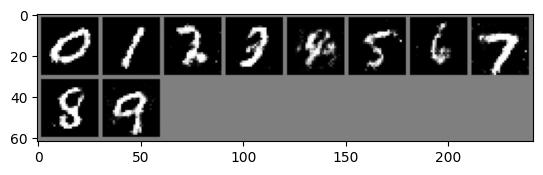

Epoch 26: 100%|██████████| 1875/1875 [00:18<00:00, 103.65it/s]


18.09098172187805
Done!


Epoch 27: 100%|██████████| 1875/1875 [00:17<00:00, 107.88it/s]


17.381505727767944
Done!


Epoch 28: 100%|██████████| 1875/1875 [00:18<00:00, 102.97it/s]


18.20985174179077
Done!


Epoch 29: 100%|██████████| 1875/1875 [00:17<00:00, 109.00it/s]


17.203373908996582
Done!


Epoch 30: 100%|██████████| 1875/1875 [00:17<00:00, 104.67it/s]


17.914708852767944
Done!


Epoch 31: 100%|█████████▉| 1869/1875 [00:17<00:00, 105.36it/s]

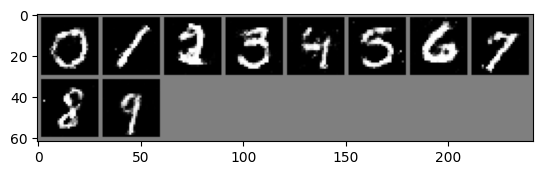

Epoch 31: 100%|██████████| 1875/1875 [00:17<00:00, 104.47it/s]


17.948253393173218
Done!


Epoch 32: 100%|██████████| 1875/1875 [00:17<00:00, 106.71it/s]


17.573029279708862
Done!


Epoch 33: 100%|██████████| 1875/1875 [00:17<00:00, 104.76it/s]


17.89835500717163
Done!


Epoch 34: 100%|██████████| 1875/1875 [00:17<00:00, 104.33it/s]


17.973318576812744
Done!


Epoch 35: 100%|██████████| 1875/1875 [00:18<00:00, 103.33it/s]


18.146769762039185
Done!


Epoch 36: 100%|█████████▉| 1871/1875 [00:17<00:00, 105.05it/s]

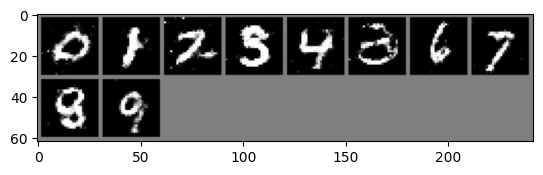

Epoch 36: 100%|██████████| 1875/1875 [00:17<00:00, 109.34it/s]


17.149418354034424
Done!


Epoch 37: 100%|██████████| 1875/1875 [00:17<00:00, 104.63it/s]


17.922148942947388
Done!


Epoch 38: 100%|██████████| 1875/1875 [00:17<00:00, 109.61it/s]


17.10692858695984
Done!


Epoch 39: 100%|██████████| 1875/1875 [00:17<00:00, 104.46it/s]


17.951332807540894
Done!


Epoch 40: 100%|██████████| 1875/1875 [00:17<00:00, 105.21it/s]


17.822738647460938
Done!


Epoch 41:  33%|███▎      | 612/1875 [00:05<00:11, 110.69it/s]


KeyboardInterrupt: 

In [27]:


generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()  # 원-핫 벡터 아님
    fake_images = generator(z, fake_labels)  # 가짜 이미지 생성
    
    validity = discriminator(fake_images, fake_labels)  
    # discriminator에 가짜 이미지를 넣어서 결과를 출력. 가짜가 라벨과 같다라고 하면 1, 아니면 0
    
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    # dis에서 나온 출력을 1로 채워져 있는 label과 비교.
    # 만약 dis가 가짜 이미지를 라벨과 같다 판단해서 1을 출력했다면은 loss는 0에 가까워진다.
    # 이를 generator가 학습. 
    # 즉, generator는 discriminator를 잘 속이는 방향(validity 가 1이 나오게)으로 학습
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()
    
    
    
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    # 진짜 이미지와 label을 discriminator에 넣는다.
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    # D가 진짜 이미지를 진짜 라고 맞추면 1을 출력하고 real_loss는 0이 됨
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()  # 임의의 Noise 생성
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    
    fake_images = generator(z, fake_labels) # Noise와 임의의 라벨을 input으로 넣음
    
    fake_validity = discriminator(fake_images, fake_labels)
    # generator가 생성한 이미지와 임의의 라벨을 discriminator에 넣어서 결과 출력 (0~1)
    
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    # real_loss를 계산할 때와는 다르게 torch.zeors를 사용해서 0으로 채워진 label을 줌.
    # discriminator가 img와 label이 같다고 판단하면 1을 출력, 아니면 0을 출력하므로 이를 CE하면
    # discriminator가 잘 맞췄을 때는 cross_entropy(1, 0) 이므로 fake_loss가 커짐
    # ---> discriminator가 진짜 이미지가 아닌 generator가 생성한 가짜 이미지를 진짜라고 판단했으므로 loss가 커짐.
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()
 
 

from torchvision.utils import make_grid
import time
import math
num_epochs = 100
n_critic = 5
display_step = 5
batch_size = btsize

for epoch in range(num_epochs):
    start = time.time()
    batch_num = math.ceil(len(train_loader.dataset) / batch_size)
    with tqdm(total=batch_num, position=0, leave=True, desc=f"Epoch {epoch + 1}") as pbar:
        # print('Starting epoch {}...'.format(epoch), end=' ')
        for i, (images, labels) in enumerate(train_loader):
            
            step = epoch * len(train_loader) + i + 1
            real_images = Variable(images).cuda()
            labels = Variable(labels).cuda()
            generator.train()
            
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                            generator, d_optimizer, criterion,
                                            real_images, labels)
            

            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
            
            #writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, step)
            
            pbar.update(1)
            
        if epoch % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(10, 100)).cuda()
            labels = Variable(torch.LongTensor(np.arange(10))).cuda()
            sample_images = generator(z, labels).unsqueeze(1)
            # plt.clf()
            imshow_grid(sample_images)
        #   writer.add_image('sample_image', grid, step)
        print(time.time()-start)
        print('Done!')
        
    


torch.randn(10, 100)

(-0.5, 271.5, 31.5, -0.5)

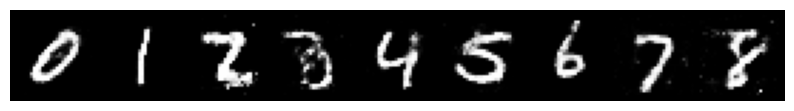

In [17]:
images = generator(z, labels).unsqueeze(1)

grid = make_grid(images, nrow=10, normalize=True)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data.cpu(), cmap='binary')
ax.axis('off')

cuda
torch.Size([50, 1, 256, 256])


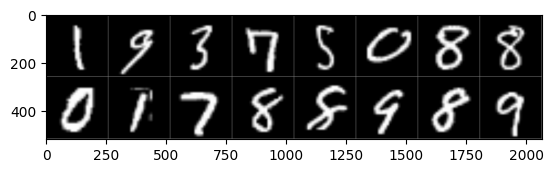

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset





is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)
paint_size = 256
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((paint_size,paint_size),antialias=True),
                    transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5))
                    ])  # 3 for RGB channels이나 실제론 gray scale

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
# 처음 400개의 데이터만 추출
subset_indices = range(1000)
subset_data = Subset(train_data, subset_indices)
subset_indices = range(100)

test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)
subsettest_data =Subset(test_data, subset_indices)
batch_size = 50

# train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True,num_workers=4)
train_data_loader = torch.utils.data.DataLoader(subset_data, batch_size, shuffle=True,num_workers=4)
test_data_loader  = torch.utils.data.DataLoader(subsettest_data, batch_size, shuffle=True,num_workers=4)
# test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True,num_workers=4)


import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = img.reshape(-1,1,paint_size,paint_size)
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = img.reshape(-1,1,paint_size,paint_size)
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
print(example_mini_batch_img.shape)
imshow_grid(example_mini_batch_img[0:16,:,:])

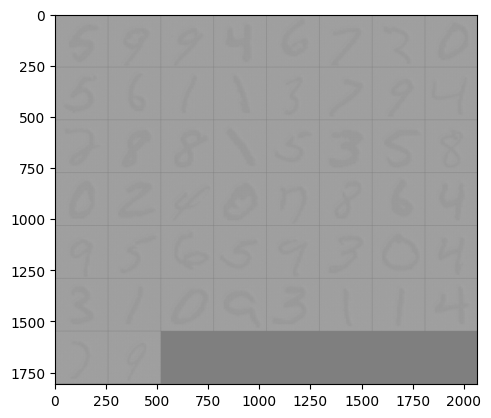

In [2]:

import torch
import torch.nn as nn
import math

#d_hidden = 12*12

class Block(nn.Module):
    def __init__(self,in_channels, out_channels, down = True, act = 'relu', use_dropout = False):
        super(Block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect')
            if down
            else
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down
    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self,in_channels=3,features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels,features,4,2,1,padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features,features*2,down=True,act='leaky',use_dropout=False)
        self.down2 = Block(features*2,features*4,down=True,act='leaky',use_dropout=False)
        self.down3 = Block(features*4,features*8,down=True,act='leaky',use_dropout=False)
        self.down4 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False)
        self.down5 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False)
        self.down6 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8,features*8,4,2,1,padding_mode='reflect'),
            nn.ReLU()
        )

        self.up1 = Block(features*8,features*8,down=False,act='relu',use_dropout=True)
        self.up2 = Block(features*8*2,features*8,down=False,act='relu',use_dropout=True)
        self.up3 = Block(features*8*2,features*8,down=False,act='relu',use_dropout=True)
        self.up4 = Block(features*8*2,features*8,down=False,act='relu',use_dropout=False)
        self.up5 = Block(features*8*2,features*4,down=False,act='relu',use_dropout=False)
        self.up6 = Block(features*4*2,features*2,down=False,act='relu',use_dropout=False)
        self.up7 = Block(features*2*2,features,down=False,act='relu',use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2,1,kernel_size=4,stride=2,padding=1),
            nn.Tanh(),
        )
        self.emb = nn.Sequential(
            nn.Embedding(10,10),
            nn.Linear(10,paint_size*paint_size),
            )
        
    def forward(self,x,y,want):
        y1 = self.emb(y)
        # print(y1.shape)
        y1 = y1.view(-1,1,paint_size,paint_size)
        want1 = self.emb(want)
        want1 = want1.view(-1,1,paint_size,paint_size)
        
        x = torch.cat([x,y1,want1],dim=1)
        
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))
    
    def test():
        x = torch.randn((1, 3, 256, 256))
        model = Generator(in_channels=3, features=64)
        preds = model(x)
        print(preds.shape)
        
# # 모델 인스턴스 생성
generator = Generator().to(device)

# x = torch.rand(1,1,paint_size,paint_size).to(device)

# label = torch.randint(1,10,(1,1)).to(device)
# # 가짜 이미지 생성하기
# img_fake = generator(x,label)
# # # 이미지 출력하기
# imshow(img_fake.cpu().detach())




def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(generator)

# # # # Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
for a, b in train_data_loader:
    real_a, real_b = a.to(device), b.to(device)
    wantlabel = torch.full((a.shape[0],1),3).to(device=device, dtype=torch.int)
    img_fake = generator(real_a,real_b,wantlabel)
    imshow_grid(img_fake)
    patch = img_fake.shape[1:4]
    break

In [9]:
import torch
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride = 2):
        super(CNNBlock,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self,x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self,in_channels = 3, features = [64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*1,features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        ) # according to paper 64 channel doesn't contain BatchNorm2d
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels,feature,stride=1 if feature==features[-1] else 2 ))
            in_channels = feature
        
        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode='reflect')
        )
        self.model = nn.Sequential(*layers)

        self.emb = nn.Sequential(
            nn.Embedding(10,10),
            nn.Linear(10,paint_size*paint_size),
            )
        
        
    def forward(self,x,y,want):
        
        y1 = self.emb(y)
        y1 = y1.view(-1,1,paint_size,paint_size)
        # print(f'y1:{y1.shape}')
        want1 = self.emb(want)
        want1 = want1.view(-1,1,paint_size,paint_size)
        # print(f'want1:{want1.shape}')
        # print(f'x:{x.shape}')
        
        
        x1 = torch.cat([x,y1,want1],dim=1)
        # print(f'x1:{x1.shape}')
        x1 = self.initial(x1)
        x1= self.model(x1)
        x1 = nn.Sigmoid()(x1)
        return x1

    def test():
        x = torch.randn((1, 3, 256, 256))
        y = torch.randn((1, 3, 256, 256))
        model = Discriminator(in_channels=3)
        preds = model(x, y)
        print(model)
        print(preds.shape)
   
   
discriminator = Discriminator().to(device)
init_params(discriminator)


for a, b in test_data_loader:
    real_a, real_b = a.to(device), b.to(device,dtype=torch.int)
    wantlabel = torch.full((real_a.shape[0],1),2).to(device=device, dtype=torch.int)
    img_fake = discriminator(real_a,real_b,wantlabel)
    
    
    # imshow_grid(img_fake)
    # print(img_fake)
    
    wantlabel = torch.randint(0,10,(real_a.size(0),1)).squeeze().to(device=device, dtype=torch.int)
    fakedata = generator(real_a,real_b,wantlabel)
    
    discriminator(fakedata, real_b , wantlabel)
    d_outsize = discriminator(real_a,real_b,wantlabel).shape[2]
    t_p_real = torch.mean( discriminator(real_a,real_b,wantlabel).reshape(-1,d_outsize*d_outsize) ,dim=1)
    
    t_p_fake = (torch.mean(discriminator(fakedata, real_b , wantlabel).reshape(-1,d_outsize*d_outsize) ,dim=1))

    p_real = t_p_real.sum()/batch_size

    p_fake = t_p_fake.sum()/batch_size
    
    
    break
# x = torch.rand(8,1,512,512).to(device)
# label = torch.randint(1,10,(8,1)).to(device)

# print(discriminator(x,label))
print(p_real,p_fake)



tensor(0.6095, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.6094, device='cuda:0', grad_fn=<DivBackward0>)


In [5]:
from tqdm import tqdm
import time       

# 손실함수
# loss_func_pix 가중치
lambda_pixel = 100

loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()



global loss_hist 
loss_hist= {'gen':[0], 'dis':[0]}
patch = (1,d_outsize,d_outsize)
def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    start = time.time()
    batch_num = math.ceil(len(subset_data)/batch_size)
    with tqdm(total=batch_num, position=0, leave=True, desc=f"Epoch {epoch + 1},  gen_loss:{loss_hist['gen'][-1]},  dis_loss:{ loss_hist['dis'][-1]} " ) as pbar:
        generator.train()
        discriminator.train()

        
        for data, label in train_data_loader:
            # c is label
                      
            #real image
            data, label = data.to(device), label.to(device)
            
            #patch label
            preal_label = torch.ones(data.size(0),*patch, requires_grad=False,dtype=torch.float32).to(device)
            pfake_label = torch.zeros(data.size(0),*patch, requires_grad=False,dtype=torch.float32).to(device)
            rlabel = torch.ones(data.size(0),1, requires_grad=False,dtype=torch.int).to(device)
            flabel = torch.zeros(data.size(0),1, requires_grad=False,dtype=torch.int).to(device)
            # wantlabel = torch.full((data.shape[0],1),2).to(device=device, dtype=torch.int)
            wantlabel = torch.randint(0,10,(data.size(0),1)).to(device=device, dtype=torch.int)
            
            
            # ================================================  #
            #generaotor
            # ================================================  #
            
            # init optimizer
            _optimizer_g.zero_grad()
      
            
            gendedata = generator(data,label,wantlabel).to(dtype=torch.float32) # 가짜 이미지 생성
            
            out_dis = discriminator(gendedata, label, wantlabel).to(dtype=torch.float32) # 가짜 이미지 식별
            # print(out_dis.shape)
            # print(out_dis)
            # print(preal_label)
            
            #pick train_data_loader ylabel == wantlabel
            # print(wantlabel)
            # print(label)
            indices_list = []
            for l in wantlabel:
                indices = torch.where(train_data.train_labels == l.cpu())
                #random index
                random_index = torch.randint(0, indices[0].size(0), (1,)).item()

                indices=indices[0][random_index]
                # print(indices)
                indices_list.append(indices.tolist())
                pixdat=train_data.train_data[indices_list].reshape(-1,1,28,28)
            # print(f'pixdata_shaep:{pixdat.shape}')                
            pixdat = pixdat.to(dtype = torch.float)
            composed_transform = transforms.Compose([  transforms.Resize((paint_size, paint_size), antialias=True),transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5))])     
            
            transformed_data = composed_transform(pixdat)
            
            gen_loss = loss_func_gan(out_dis, preal_label) #가짜를 진짜처럼
            
            
            pixel_loss = loss_func_pix(gendedata, transformed_data.to(device))
            
            loss_d = gen_loss + lambda_pixel * pixel_loss
            loss_d.backward()
            _optimizer_g.step()
            


            # ================================================  #
            #                  # discriminator      #
            # ================================================  #

            # init optimizer
            # print(label)
            # print(flabel) 
            _optimizer_d.zero_grad()
            
            gendedata = generator(data,label,wantlabel).to(dtype=torch.float32) # 가짜 이미지 생성
            
            
            out_dis = discriminator(data, label ,wantlabel) # 진짜 이미지 식별
            real_loss = loss_func_gan(out_dis,preal_label)
            
             
            out_dis = discriminator(gendedata.detach(), label,wantlabel) # 가짜 이미지 식별
            fake_loss = loss_func_gan(out_dis,pfake_label)

            loss_g = (real_loss + fake_loss) / 2.
            loss_g.backward()
            _optimizer_d.step()

            loss_hist['gen'].append(round(loss_g.item(),6))
            loss_hist['dis'].append(round(loss_d.item(),6))

            
            pbar.update(1)
            

    # print(time.time()-start)
        
    
def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()
    #test_data_loader
    for data, label in test_data_loader:
        t_p_real,t_p_real = 0,0
        with torch.autograd.no_grad():
            data,label= data.to(device), label.to(device)
            wantlabel = torch.randint(0,10,(data.size(0),1)).to(device=device, dtype=torch.int)
            # wantlabel = torch.randint(0,10,(data.size(0),1)).to(device=device, dtype=torch.int)
            fakedata = generator(data,label,wantlabel)
            t_p_real = torch.mean(discriminator(data,label,wantlabel).reshape(-1,d_outsize*d_outsize) ,dim=1)
            t_p_fake = (torch.mean(discriminator(fakedata,label , wantlabel).reshape(-1,d_outsize*d_outsize) ,dim=1))
            p_real = t_p_real.sum()/batch_size

            p_fake = t_p_fake.sum()/batch_size
            
 
    #test_data.tes
    #train
    if((epoch+1)% 10 == 0):
        with torch.autograd.no_grad():
            generator.eval()
            discriminator.eval()    
            # wantlabel = torch.full((data.shape[0],1),2).to(device=device, dtype=torch.int)
            wantlabel = torch.randint(0,10,(data.size(0),1)).to(device=device, dtype=torch.int)
            indices_list = []
            for l in wantlabel:
                indices = torch.where(test_data.test_labels == l.cpu())
                random_index = torch.randint(0, indices[0].size(0), (1,)).item()
                indices=indices[0][random_index]

                # print(indices)
                indices_list.append(indices.tolist())
                pixdat=test_data.test_data[indices_list].reshape(-1,1,28,28)
            pixdat = pixdat.to(dtype = torch.float)
            # print(f'pixdata_shaep:{pixdat.shape}')                
            composed_transform = transforms.Compose([  transforms.Resize((paint_size, paint_size), antialias=True), transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5))])  
               
            transformed_data = composed_transform(pixdat)
            
            
            
            
            fake_imgs = generator( data.to(device), label.to(device),wantlabel ).cpu()
            real_imgs = data.cpu()

            img = torch.cat( (real_imgs[0:2],transformed_data[0:2],fake_imgs[0:2]), 0)
            imshow_grid((img))
    
    return p_real.cpu(), p_fake.cpu()

Epoch 1,  gen_loss:0,  dis_loss:0 :   0%|          | 0/20 [00:00<?, ?it/s]/home/yunkwan/pytorch/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/yunkwan/pytorch/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
Epoch 1,  gen_loss:0,  dis_loss:0 : 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]
Epoch 2,  gen_loss:0.576425,  dis_loss:6682.676758 : 100%|██████████| 20/20 [00:05<00:00,  3.82it/s]
Epoch 3,  gen_loss:0.401821,  dis_loss:6595.727539 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 4,  gen_loss:0.297743,  dis_loss:7188.616211 : 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
Epoch 5,  gen_loss:0.316609,  dis_loss:7178.362793 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 6,  gen_loss:0.338214,  dis_loss:7020.592773 : 100%|████

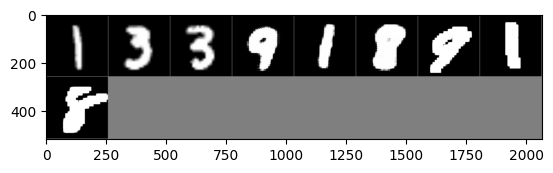

Epoch 51,  gen_loss:0.00468,  dis_loss:6672.133789 : 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
Epoch 52,  gen_loss:0.003022,  dis_loss:6309.62207 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 53,  gen_loss:0.002593,  dis_loss:6652.244629 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 54,  gen_loss:0.002865,  dis_loss:6860.197754 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 55,  gen_loss:0.0024,  dis_loss:6634.699707 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 56,  gen_loss:0.002476,  dis_loss:6322.657715 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 57,  gen_loss:0.003244,  dis_loss:6999.541504 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 58,  gen_loss:0.002283,  dis_loss:6618.028809 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 59,  gen_loss:0.002335,  dis_loss:6493.963379 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 60,  gen_loss:0.002066,  dis_loss:7122.961914 : 100%|██████████| 20/20 [00:05<00

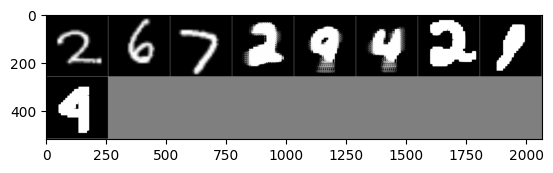

Epoch 101,  gen_loss:0.000649,  dis_loss:6499.59375 : 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]
Epoch 102,  gen_loss:0.000711,  dis_loss:6844.910645 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 103,  gen_loss:0.000819,  dis_loss:5972.296875 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 104,  gen_loss:0.00071,  dis_loss:6741.940918 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 105,  gen_loss:0.000631,  dis_loss:6847.553223 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 106,  gen_loss:0.000632,  dis_loss:6500.493652 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 107,  gen_loss:0.000579,  dis_loss:6518.465332 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 108,  gen_loss:0.000559,  dis_loss:6204.143555 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 109,  gen_loss:0.00069,  dis_loss:6238.035645 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 110,  gen_loss:0.001147,  dis_loss:6519.687012 : 100%|██████████| 20/2

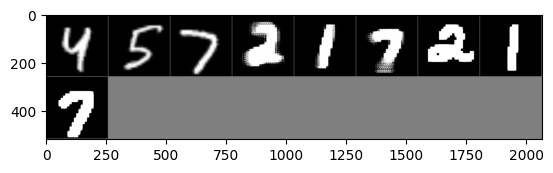

Epoch 151,  gen_loss:0.000263,  dis_loss:6902.128418 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 152,  gen_loss:0.000293,  dis_loss:6560.220215 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 153,  gen_loss:0.000241,  dis_loss:6693.453613 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 154,  gen_loss:0.000256,  dis_loss:6608.447754 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 155,  gen_loss:0.000237,  dis_loss:6470.736816 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 156,  gen_loss:0.000233,  dis_loss:6505.995605 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 157,  gen_loss:0.000231,  dis_loss:6499.588867 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 158,  gen_loss:0.000216,  dis_loss:6763.57666 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 159,  gen_loss:0.000214,  dis_loss:6701.871094 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 160,  gen_loss:0.000231,  dis_loss:7154.070312 : 100%|██████████| 20

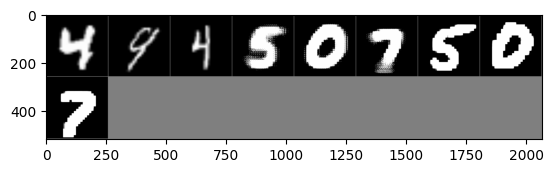

Epoch 201,  gen_loss:0.000106,  dis_loss:7024.316406 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 202,  gen_loss:9.8e-05,  dis_loss:6443.359863 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 203,  gen_loss:0.000121,  dis_loss:6696.814941 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 204,  gen_loss:0.000121,  dis_loss:6940.37207 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 205,  gen_loss:9.3e-05,  dis_loss:7255.072266 : 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
Epoch 206,  gen_loss:9.4e-05,  dis_loss:6854.872559 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 207,  gen_loss:9.5e-05,  dis_loss:7442.53125 : 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
Epoch 208,  gen_loss:0.000116,  dis_loss:6746.686035 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 209,  gen_loss:9.7e-05,  dis_loss:7033.679688 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 210,  gen_loss:0.000139,  dis_loss:6640.611816 : 100%|██████████| 20/20 [0

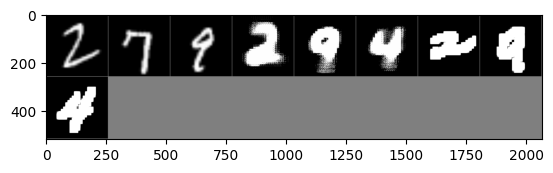

Epoch 251,  gen_loss:5.4e-05,  dis_loss:6252.763184 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 252,  gen_loss:5.3e-05,  dis_loss:6228.151855 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 253,  gen_loss:5e-05,  dis_loss:6695.772949 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 254,  gen_loss:5.1e-05,  dis_loss:7418.115234 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 255,  gen_loss:5e-05,  dis_loss:6966.019043 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 256,  gen_loss:4.8e-05,  dis_loss:6789.174316 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 257,  gen_loss:4.8e-05,  dis_loss:7063.267578 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 258,  gen_loss:4.8e-05,  dis_loss:6252.37207 : 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
Epoch 259,  gen_loss:4.8e-05,  dis_loss:6554.365234 : 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]
Epoch 260,  gen_loss:5.3e-05,  dis_loss:6594.638184 : 100%|██████████| 20/20 [00:05<00:

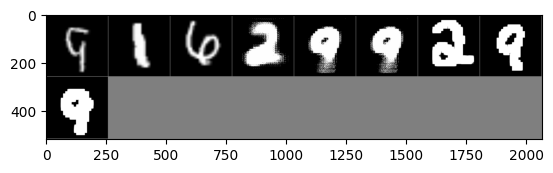

Epoch 301,  gen_loss:4e-05,  dis_loss:6923.351562 : 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]
Epoch 302,  gen_loss:3e-05,  dis_loss:6380.288574 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 303,  gen_loss:2.7e-05,  dis_loss:6614.209473 : 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]
Epoch 304,  gen_loss:2.6e-05,  dis_loss:6775.532715 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 305,  gen_loss:2.7e-05,  dis_loss:6644.460449 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 306,  gen_loss:2.6e-05,  dis_loss:6551.260742 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 307,  gen_loss:3e-05,  dis_loss:6097.444824 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 308,  gen_loss:3.2e-05,  dis_loss:6418.931152 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 309,  gen_loss:2.6e-05,  dis_loss:6669.705078 : 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]
Epoch 310,  gen_loss:3.2e-05,  dis_loss:6557.086914 : 100%|██████████| 20/20 [00:05<00:0

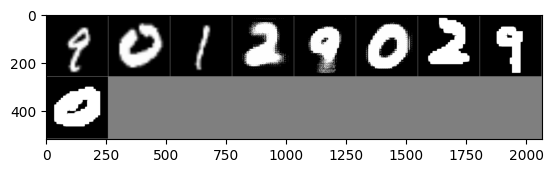

Epoch 351,  gen_loss:1.9e-05,  dis_loss:7000.346191 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 352,  gen_loss:1.6e-05,  dis_loss:6538.875977 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 353,  gen_loss:1.6e-05,  dis_loss:6592.740234 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 354,  gen_loss:1.6e-05,  dis_loss:6349.721191 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 355,  gen_loss:1.5e-05,  dis_loss:6582.55127 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 356,  gen_loss:1.5e-05,  dis_loss:6936.568359 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 357,  gen_loss:1.5e-05,  dis_loss:6462.984375 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 358,  gen_loss:1.4e-05,  dis_loss:6545.945312 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 359,  gen_loss:1.5e-05,  dis_loss:6808.357422 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 360,  gen_loss:1.5e-05,  dis_loss:6187.043945 : 100%|██████████| 20/20 [00:05

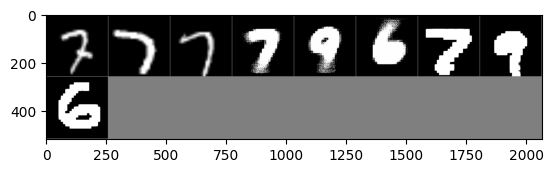

Epoch 401,  gen_loss:9e-06,  dis_loss:6784.416016 : 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]
Epoch 402,  gen_loss:1e-05,  dis_loss:6022.123535 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 403,  gen_loss:9e-06,  dis_loss:6738.745117 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 404,  gen_loss:1e-05,  dis_loss:6603.970703 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 405,  gen_loss:9e-06,  dis_loss:6809.906738 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 406,  gen_loss:9e-06,  dis_loss:6832.508301 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 407,  gen_loss:8e-06,  dis_loss:6252.286133 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 408,  gen_loss:8e-06,  dis_loss:6682.943848 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 409,  gen_loss:8e-06,  dis_loss:6900.578613 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 410,  gen_loss:8e-06,  dis_loss:6864.908203 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


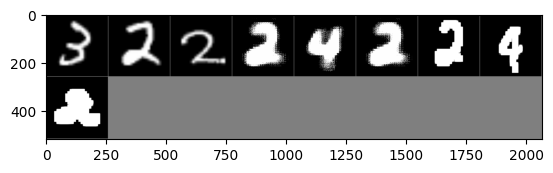

Epoch 451,  gen_loss:6e-06,  dis_loss:6656.22998 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 452,  gen_loss:5e-06,  dis_loss:6903.127441 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 453,  gen_loss:5e-06,  dis_loss:6531.779297 : 100%|██████████| 20/20 [00:05<00:00,  3.75it/s]
Epoch 454,  gen_loss:5e-06,  dis_loss:6734.601562 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 455,  gen_loss:5e-06,  dis_loss:6328.856445 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
Epoch 456,  gen_loss:5e-06,  dis_loss:6526.666992 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 457,  gen_loss:5e-06,  dis_loss:6676.168457 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 458,  gen_loss:5e-06,  dis_loss:7166.969727 : 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]
Epoch 459,  gen_loss:5e-06,  dis_loss:6771.916016 : 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]
Epoch 460,  gen_loss:5e-06,  dis_loss:6997.854004 : 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
E

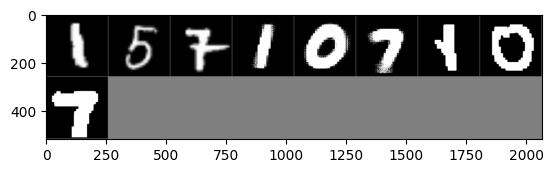

In [6]:
# new


def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

# init_params(generator)
# init_params(discriminator)

_optimizer_g = optim.Adam(generator.parameters(), lr = 0.0002)
_optimizer_d = optim.Adam(discriminator.parameters(), lr = 0.0002)

p_real_trace = []

p_fake_trace = []



# batch_num = math.ceil(len(train_data)/batch_size)
# datanum =  math.ceil(len(test_data)/batch_size)
# print(batch_num)

for epoch in range(500):
    # print(epoch)
    run_epoch(generator.to(device), discriminator.to(device), _optimizer_g, _optimizer_d)

    p_real, p_fake = evaluate_model(generator,discriminator)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)
    # print('dd')



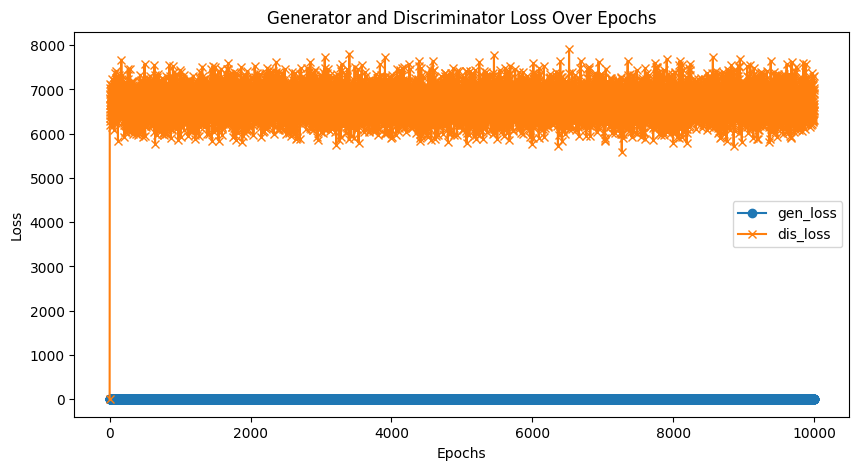

In [7]:
import matplotlib.pyplot as plt

# loss_hist 딕셔너리에서 'gen'과 'dis'의 값을 가져옵니다.
gen_losses = loss_hist['gen']
dis_losses = loss_hist['dis']

# x 축은 에폭 번호로 설정합니다. (예: 0, 1, 2, ...)
epochs = list(range(len(gen_losses)))

# 'gen'과 'dis'의 손실 값을 플롯합니다.
plt.figure(figsize=(10, 5))
plt.plot(epochs, gen_losses, label='gen_loss', marker='o')
plt.plot(epochs, dis_losses, label='dis_loss', marker='x')

# 그래프에 제목과 레이블을 추가합니다.
plt.title('Generator and Discriminator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프를 표시합니다.
plt.show()


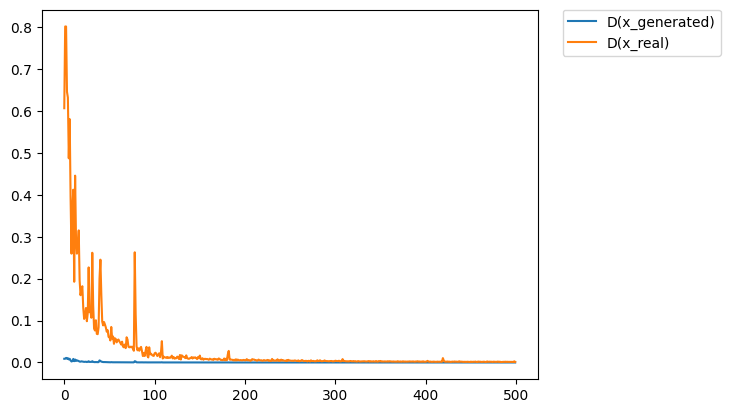

In [8]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()